In [39]:
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)
import requests
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import random
import numpy as np
import pandas as pd
import itertools
from sklearn import svm
from sklearn import tree
from urllib import request
from random import randint
#from wordcloud import WordCloud
from nltk import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import gensim
from gensim.models import LdaModel, Word2Vec
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.stem import WordNetLemmatizer
#!pip install mlxtend
#from mlxtend.evaluate import bias_variance_decomp
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import silhouette_samples, silhouette_score, homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, euclidean_distances 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hadyo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hadyo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hadyo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#fitting Hierarchical model
def model_HC(data):
    HC = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
    y_data = HC.fit_predict(data)
    return y_data, HC

In [3]:
def plotting(features, y_pred, model, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(features[y_pred == 0, 0],
                features[y_pred == 0, 1], marker = "x", c = 'red', s = 100, label = ['c1'])
    plt.scatter(features[y_pred == 1, 0],
                features[y_pred == 1, 1], marker = "x", c = 'blue', s = 100, label = ['c2'])
    plt.scatter(features[y_pred == 2, 0],
                features[y_pred == 2, 1], marker = "x", c = 'orange', s = 100, label = ['c3'])
    plt.scatter(features[y_pred == 3, 0],
                features[y_pred == 3, 1], marker = "x", c = 'yellow', s = 100, label = ['c4'])
    plt.scatter(features[y_pred == 4, 0],
                features[y_pred == 4, 1], marker = "x", c = 'green', s = 100, label = ['c5'])
    plt.legend()
    plt.title(title)

In [4]:
#evaluate the clusters
def clustering_evaluation(features, clustering_labels, data):
    print("Homogeneity: {}".format(homogeneity_score(data, clustering_labels)))
    print("Completeness: {}".format(completeness_score(data, clustering_labels)))
    print("V-measure: {}".format(v_measure_score(data, clustering_labels)))
    print("Adjusted Rand-Index: {}".format(adjusted_rand_score(data, clustering_labels)))
    print("Silhouette Coefficient: {}".format(silhouette_score(features, clustering_labels)))

In [5]:
books_url_list = ["https://www.gutenberg.org/files/84/84-0.txt",
                  "https://www.gutenberg.org/cache/epub/28434/pg28434.txt",
                  "https://www.gutenberg.org/cache/epub/3623/pg3623.txt",
                  "https://www.gutenberg.org/cache/epub/17866/pg17866.txt",
                  "https://www.gutenberg.org/files/3772/3772-0.txt"]

# Preprocessing

In [6]:
#function read raw data
def read_books(url):
    files = []
    for i in url:
        file = requests.get(url = i)
        files.append(file.content.decode('utf-8'))
    return files

#read raw data
raw_dataset = read_books(books_url_list)
len(raw_dataset)

5

In [7]:
#Function cleaned tokens
def cleaned_text(raw_text):
    text_beg = raw_text.find("*** START OF")
    text_end = raw_text.find("*** END OF")

    raw_text = raw_text[text_beg : text_end]
    raw_text = re.findall(r"[a-zA-Z]+", raw_text)
    raw_text = " ".join(raw_text).lower()
    tokens = word_tokenize(raw_text)
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return tokens
#Getting cleaned tokens
tokens = []
for i in range(len(raw_dataset)):
    tokens.append(cleaned_text(raw_dataset[i]))
len(tokens)

5

In [8]:
#function to extract author name, book name and labels
def extract_book_author(raw_text, index):
    label = chr(index + 97)
        
    title_beg = raw_text.find("Title") + 7
    title_end = raw_text.find("\r\n\r\nAuthor")
    title = raw_text[title_beg : title_end]

    author_beg = raw_text.find("Author") + 8
    c = 0
    while raw_text[author_beg + c] != "\r":
        c += 1
        author_end = author_beg + c
    author = raw_text[author_beg : author_end]
    return label, title, author

#getting the author name, book name, labels
label, author, title = [], [], []
for i in range(len(raw_dataset)):
    label_temp, title_temp, author_temp = extract_book_author(raw_dataset[i],i)
    label.append(label_temp)
    author.append(author_temp)
    title.append(title_temp)
    
print(len(label))
print(len(author))
print(len(title))
print(len(tokens))

5
5
5
5


In [9]:
#function to partition data
def partitioned_text(tokens, title, author, label):
    book_partitions = []
    for i in range(0, len(tokens) -150, 150):
        partition = [" ".join(tokens[i : i + 150]), title, author, label]
        book_partitions.append(partition)
    return book_partitions

In [10]:
partitions = []
for i in range(len(books_url_list)):
    book_partitions = partitioned_text(tokens[i], title[i], author[i], label[i])
    random.shuffle(book_partitions)
    book_partitions = book_partitions[0:200]
    partitions += book_partitions

dataset = pd.DataFrame(partitions, columns = ["partitions", "title", "author", "label"])
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset

,partitions,title,author,label
0,happier time contemplated day company shadow r...,"Frankenstein\r\n or, The Modern Prometheus",Mary Wollstonecraft (Godwin) Shelley,a
1,phenomenon observed connection variable appear...,The Astronomy of Milton's 'Paradise Lost',Thomas Orchard,b
2,crust thrown together confusedly distinct mine...,The Student’s Elements of Geology,Sir Charles Lyell,e
3,cutting shale striking example near plas newyd...,The Student’s Elements of Geology,Sir Charles Lyell,e
4,blood carefully collected afterwards swallowed...,The Golden Bough\r\n A study of magic an...,Sir James George Frazer,c
...,...,...,...,...
995,distributing scanty meal five hungry babe amon...,"Frankenstein\r\n or, The Modern Prometheus",Mary Wollstonecraft (Godwin) Shelley,a
996,jefferson davis rand cost loss expensive libel...,Murder in the Gunroom,Henry Beam Piper,d
997,de la beche muddy bottom sea received small su...,The Student’s Elements of Geology,Sir Charles Lyell,e
998,broth prepared consumed occasion guest honour ...,The Golden Bough\r\n A study of magic an...,Sir James George Frazer,c


# Feature Engineering

## BOW model

In [11]:
def model_BOW(data): # take the partitions
    cv = CountVectorizer()
    cv_fit = cv.fit_transform(data)
    cv_fit_df = pd.DataFrame(cv_fit.toarray(), columns = cv.get_feature_names())
    return cv_fit_df
    
bow_vectorizer = model_BOW(dataset['partitions'])
bow_vectorizer

,aachen,aah,aargau,aaron,aarvo,aba,aback,abandon,abandoned,abated,...,zoon,zoophagous,zoophyte,zorger,zostera,zouch,zu,zulu,zum,zytniamatka
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF model

In [12]:
def model_TFIDF(data): # take the partitions
    tfIdf = TfidfVectorizer(use_idf=True)
    tfidf_fit = tfIdf.fit_transform(data).toarray()
    tfidf_fit_df = pd.DataFrame(tfidf_fit, columns = tfIdf.get_feature_names())
    return tfidf_fit_df

tfidf_vectorizer = model_TFIDF(dataset['partitions'])
tfidf_vectorizer

,aachen,aah,aargau,aaron,aarvo,aba,aback,abandon,abandoned,abated,...,zoon,zoophagous,zoophyte,zorger,zostera,zouch,zu,zulu,zum,zytniamatka
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## LDA as a feature extractor

In [13]:
def model_LDA2(data): # take the partitions
    cv = CountVectorizer(max_df = 0.9, min_df = 2)
    dtm = cv.fit_transform(data)
    lda = LatentDirichletAllocation(n_components = 5, random_state = 5)
    lda = lda.fit_transform(dtm)
    return lda

lda = model_LDA2(dataset['partitions'])
lda

array([[0.02851121, 0.96740214, 0.00136445, 0.00136159, 0.0013606 ],
       [0.00142122, 0.00142057, 0.20173385, 0.00141453, 0.79400982],
       [0.81288529, 0.05833501, 0.00141272, 0.00139953, 0.12596746],
       ...,
       [0.92656732, 0.06899577, 0.0014683 , 0.00148402, 0.00148459],
       [0.00140868, 0.75559235, 0.07043481, 0.00139134, 0.17117283],
       [0.00140393, 0.00140247, 0.99394291, 0.00139097, 0.00185973]])

## wordembedding model

In [14]:
#splitting the sentences in each partitoin
partitions_splitted = []
for partition in dataset['partitions']:
    temp = partition.split()
    partitions_splitted.append(temp)


In [15]:
#creating the word2vec model
def model_word2vec(tokens_data): # take the partitions_splitted
    model = Word2Vec(sentences = tokens_data, vector_size = 150, workers = 6)
    return model

In [16]:
word2vec_model = model_word2vec(partitions_splitted)
word2vec_model

In [17]:
#Create the word document vectors
def doc_vectors(data_tokens, word2vec_model):
    features = []
    for tokens in data_tokens:
        zero_vector = np.zeros(word2vec_model.vector_size)
        vectors = []
        for token in tokens:
            if token in word2vec_model.wv:
                vectors.append(word2vec_model.wv[token])
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis = 0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

vectorized_doc = doc_vectors(partitions_splitted, word2vec_model) #vectorized documents


In [18]:
len(vectorized_doc), len(vectorized_doc[0])

(1000, 150)

## Hierarchical Clustering + BOW

In [19]:
bow_features_reduced = KernelPCA(n_components = 2, eigen_solver = 'dense').fit_transform(bow_vectorizer)

In [20]:
#fitting the model with the bow
y_data_HC_bow, model_HC_bow = model_HC(bow_features_reduced)


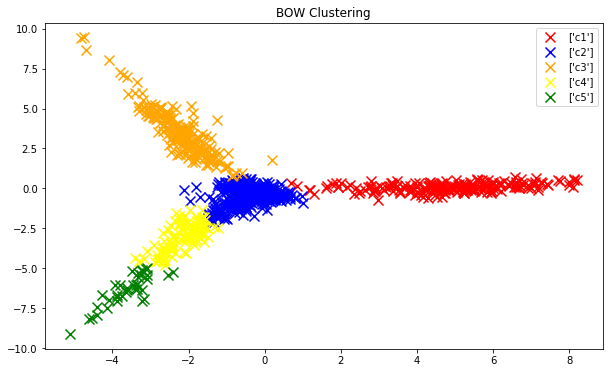

In [21]:
plotting(bow_features_reduced, y_data_HC_bow, model_HC_bow, 'BOW Clustering')

In [22]:
clustering_evaluation(bow_features_reduced, model_HC_bow.labels_, dataset['label'])

Homogeneity: 0.6903400988214664
Completeness: 0.8170746729620073
V-measure: 0.7483798368378088
Adjusted Rand-Index: 0.5864701209912095
Silhouette Coefficient: 0.6250833462941792


## Hierarchical Clustering + TFIDF

In [23]:
bow_features_reduced_tfidf = KernelPCA(n_components = 2, eigen_solver = 'dense').fit_transform(tfidf_vectorizer)

In [24]:
#fitting the model with the bow
y_data_HC_tfidf, model_HC_tfidf = model_HC(bow_features_reduced_tfidf)

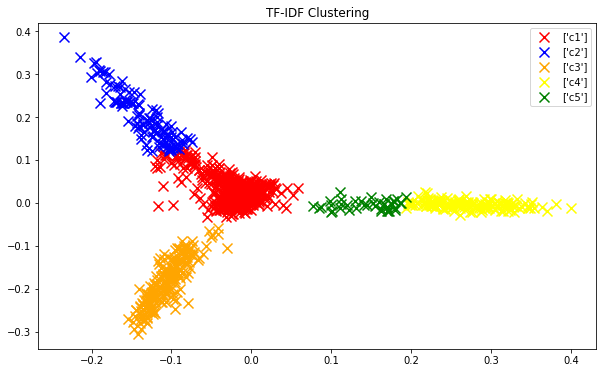

In [25]:
plotting(bow_features_reduced_tfidf, y_data_HC_tfidf, model_HC_tfidf, 'TF-IDF Clustering')

In [26]:
clustering_evaluation(bow_features_reduced_tfidf, model_HC_tfidf.labels_, dataset['label'])

Homogeneity: 0.6900425155926684
Completeness: 0.8248602086494657
V-measure: 0.7514523596536811
Adjusted Rand-Index: 0.5389309930377986
Silhouette Coefficient: 0.6261719940132334


## Hierarchical Clustering  + LDA

In [27]:
bow_features_reduced_lda = KernelPCA(n_components = 2, eigen_solver = 'dense').fit_transform(lda)

In [28]:
#fitting the model with the bow
y_data_HC_lda, model_HC_lda = model_HC(bow_features_reduced_lda)

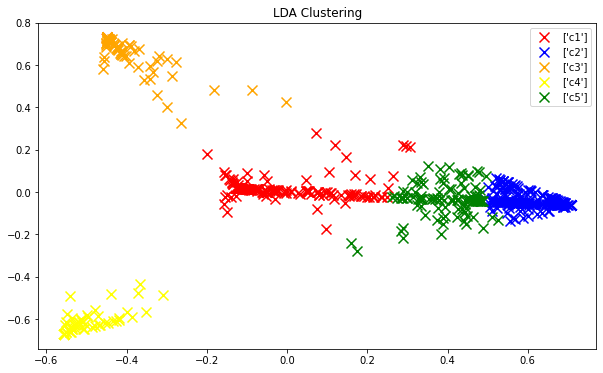

In [29]:
plotting(bow_features_reduced_lda, y_data_HC_lda, model_HC_lda, 'LDA Clustering')

In [30]:
clustering_evaluation(bow_features_reduced_lda, model_HC_lda.labels_, dataset['label'])

Homogeneity: 0.745316493102089
Completeness: 0.7613422023760905
V-measure: 0.7532441182977752
Adjusted Rand-Index: 0.6946673135675593
Silhouette Coefficient: 0.7235943913207931


## KMeans + wordEmbedding

In [31]:
bow_features_reduced_we = KernelPCA(n_components = 2, eigen_solver = 'dense').fit_transform(vectorized_doc)

In [32]:
#fitting KMeans model with the LDA
y_data_HC_we, model_HC_we = model_HC(bow_features_reduced_we)

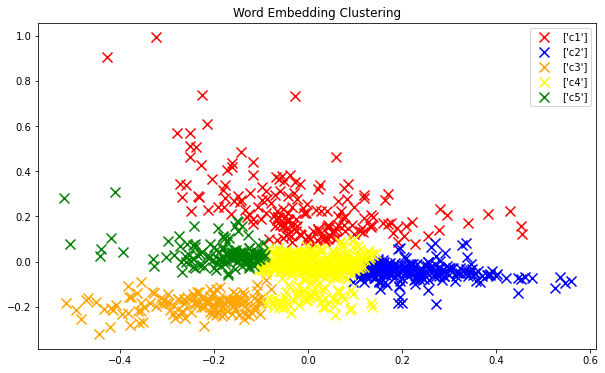

In [33]:
plotting(bow_features_reduced_we, y_data_HC_we, model_HC_we, 'Word Embedding Clustering')

In [34]:
clustering_evaluation(bow_features_reduced_we, model_HC_we.labels_, dataset['label'])

Homogeneity: 0.39715334582318895
Completeness: 0.41749909621498693
V-measure: 0.4070721558879692
Adjusted Rand-Index: 0.28590735940220385
Silhouette Coefficient: 0.35542604327201843


In [ ]:
clf = NearestCentroid()
clf.fit(X, y_predict)
print(clf.centroids_)

In [40]:
def distance_btw_clusters(data, predicted_data):
    clf = NearestCentroid()
    clf.fit(data, predicted_data)
    dists = euclidean_distances(clf.centroids_)
    tri_dists = dists[np.triu_indices(5, 1)]
    max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()
    return max_dist, avg_dist, min_dist

In [42]:
max_dist, avg_dist, min_dist = distance_btw_clusters(bow_vectorizer, y_data_HC_bow)

In [43]:
max_dist

11.647371118273755

In [44]:
avg_dist

7.983308114676042

In [45]:
min_dist

5.149441205151195